In [1]:
# Import ratinabox
import ratinabox
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from ratinabox.Neurons import *
from tqdm.notebook import tqdm  # gives time bar
import numpy as np
import brainpy.math as bm
import jax
import brainpy as bp

from models import PC_cell, BV_cell
from utils import * 

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
import seaborn as sns

#stylize plots and set figure directory for saving 
ratinabox.stylize_plots(); ratinabox.autosave_plots=True; ratinabox.figure_directory="./figures/"

%load_ext autoreload
%autoreload 2

In [2]:
# Run simulation 
t, Position, HD_angle, Speed, Env = simulate_agent_in_environment(duration=3600, dt=50e-3, speed_mean=1.0, start_pos=(0.5, 0.5), addwall=True)

  0%|          | 0/72000 [00:00<?, ?it/s]

### Create Boundary Vector Cell

In [ ]:
# Simulate agent and get response
t, Position, HD_angle, Speed, Env = simulate_agent_in_environment(duration=300, dt=50e-3, speed_mean=1.0, start_pos=(0.5, 0.5))

# BVC parameters
d_i = 0.9 # Preferred distance of the BVC.
allo_ang = 90
phi_i = np.deg2rad(allo_ang) # Preferred allocentric angle of the BVC (radians).
sigma_ang = np.deg2rad(20)
beta = 0.2
sigma0 = 0.05

# Define environment boundaries (square box from 0 to 1)
boundary_segments = 360  # Number of segments for boundary discretisation
boundary_angles = np.linspace(-np.pi, np.pi, boundary_segments, endpoint=False)
delta_theta = 2 * np.pi / boundary_segments  # Angular width of each segment
addnoise = False

# Compute firing rate 
firing_rates = compute_BVC_firing_rate(Position, boundary_angles, delta_theta, phi_i, d_i, sigma_ang, beta, sigma0, addnoise=addnoise)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

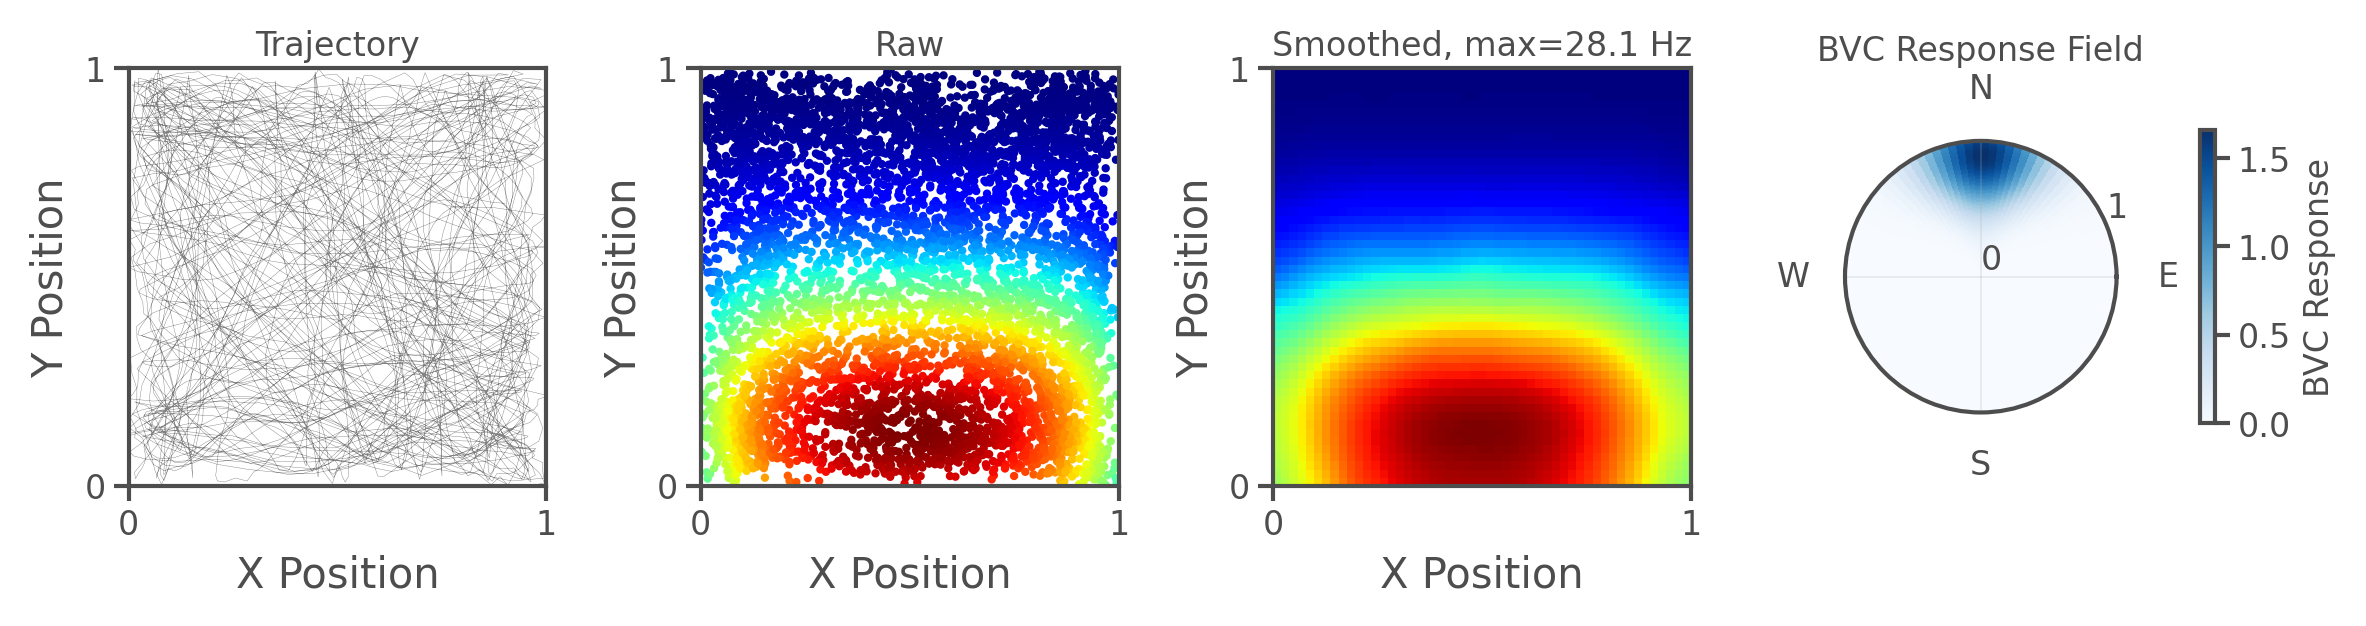

In [ ]:
# Plot firing rate maps

# Create a single figure with 4 subplots (3 cartesian + 1 polar)
fig = plt.figure(figsize=(8, 2), dpi=300)

# -------------------------
# 1. Trajectory plot
ax1 = fig.add_subplot(1, 4, 1)
ax1.plot(Position[:,0], Position[:,1], lw=0.1, color='grey')

ax1.set_xlabel('X Position')
ax1.set_ylabel('Y Position')
ax1.set_aspect('equal')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_title("Trajectory")

# -------------------------
# 2. Raw firing map (scatter)
ax2 = fig.add_subplot(1, 4, 2)
sc = ax2.scatter(Position[:,0], Position[:,1], c=firing_rates, cmap='jet', s=1)

ax2.set_xlabel('X Position')
ax2.set_ylabel('Y Position')
ax2.set_aspect('equal')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_xticks([0, 1])
ax2.set_yticks([0, 1])
ax2.set_title("Raw")

# plt.colorbar(sc, ax=ax2, label='Firing Rate (Hz)', pad=0.2, shrink=0.7)

# -------------------------
# 3. Smoothed rate map
rate_map, dwell_times, spike_counts, extent = compute_firing_rate_map(Position, firing_rates, t, bin_size=0.02, smoothing="gaussian")

ax3 = fig.add_subplot(1, 4, 3)
c = ax3.imshow(rate_map.T, origin='lower', extent=[0, 1, 0, 1],
               cmap='jet', interpolation='nearest')

ax3.set_xlabel('X Position')
ax3.set_ylabel('Y Position')
ax3.set_aspect('equal')
max_fr_raw = np.nanmax(rate_map)
ax3.set_title(f"Smoothed, max={max_fr_raw:.1f} Hz")
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])
ax3.set_xticks([0, 1])
ax3.set_yticks([0, 1])

# plt.colorbar(c, ax=ax3, label='Firing Rate (Hz)', pad=0.2, shrink=0.7)

# -------------------------
# 4. BVC Polar Tuning
ax4 = fig.add_subplot(1, 4, 4, projection='polar')

r = np.linspace(0, 1, 100)
theta = np.linspace(-np.pi, np.pi, 100)
Theta, R = np.meshgrid(theta, r)
response = BVC_response(Theta, R, phi_i, d_i, sigma_ang, beta, sigma0)

r_edges = np.linspace(r.min(), r.max(), len(r)+1)
theta_edges = np.linspace(theta.min(), theta.max(), len(theta)+1)

pcm = ax4.pcolormesh(theta_edges, r_edges, response, cmap='Blues', shading='auto')
plt.colorbar(pcm, ax=ax4, label='BVC Response', pad=0.2, shrink=0.7)

ax4.set_title("BVC Response Field")
ax4.set_theta_zero_location("E")
ax4.set_theta_direction(1)
ax4.set_ylim(0, 1)
ax4.set_yticks([0, 1])
ax4.set_thetagrids([0, 90, 180, 270], labels=['E', 'N', 'W', 'S'])

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel(ax.get_xlabel(), fontsize=10)
    ax.set_ylabel(ax.get_ylabel(), fontsize=10)

# -------------------------
# Final layout
plt.tight_layout()

# if not addnoise:
#     plt.savefig('/Users/athinaapostolelli/Documents/SWC/VTC_modelling/figures/BVCs/BVC_'+str(d_i)+'_'+str(allo_ang)+'.png')
# else:
#     plt.savefig('/Users/athinaapostolelli/Documents/SWC/VTC_modelling/figures/BVCs/BVC_'+str(d_i)+'_'+str(allo_ang)+'addnoise.png')


  0%|          | 0/6000 [00:00<?, ?it/s]

Figure saved to /Users/athinaapostolelli/Documents/SWC/VTC_modelling/figures/25_09_11/BoundaryVectorCells_ratemaps_1505.png  & .svg


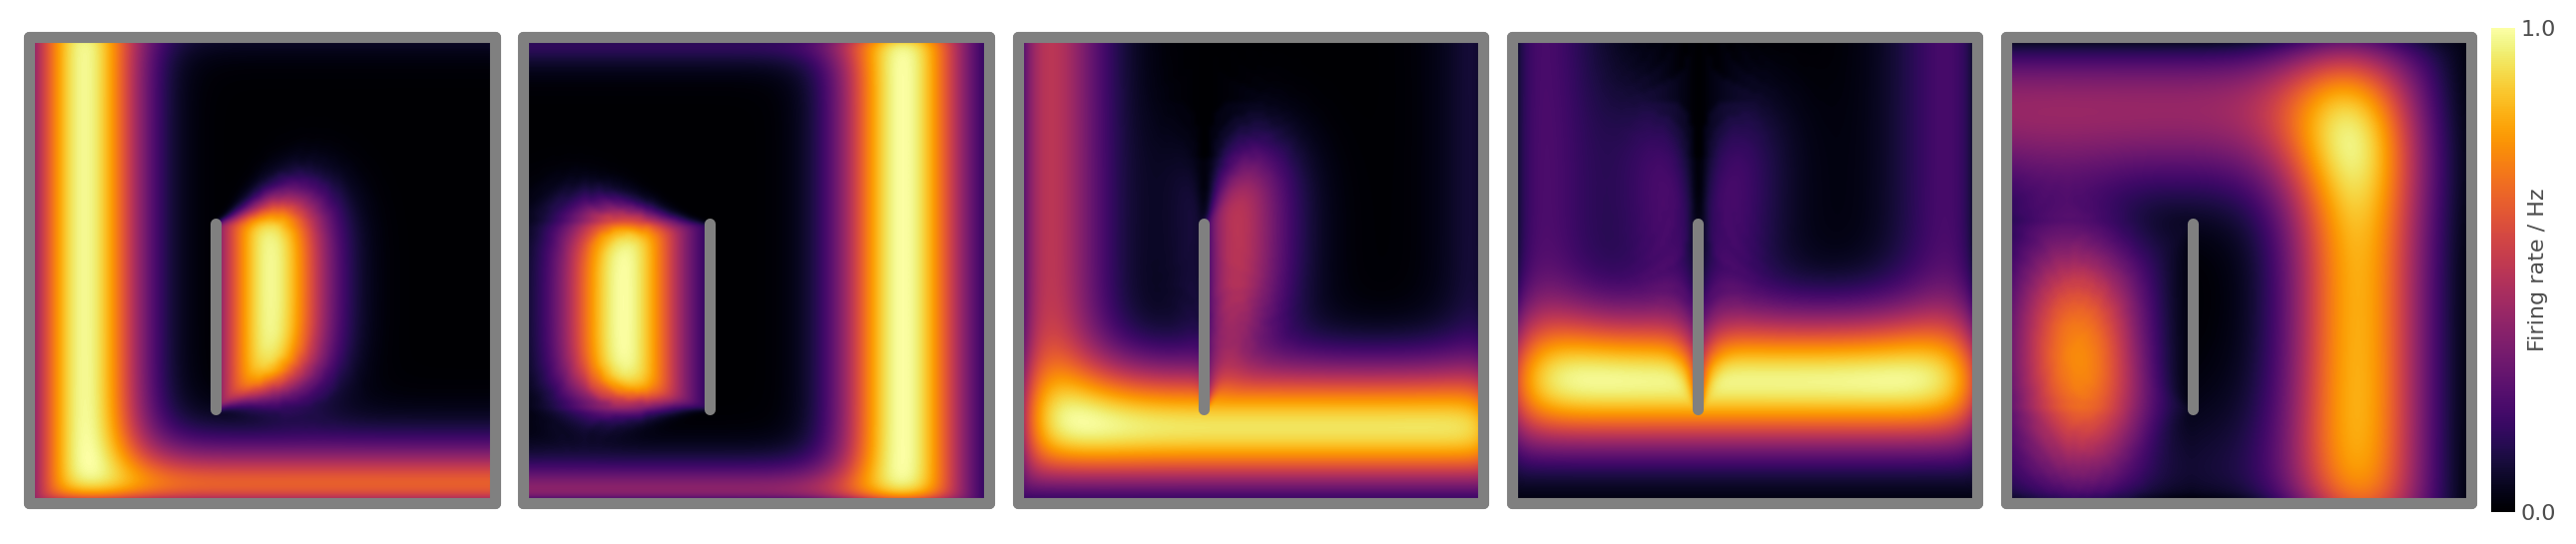

In [ ]:
# Model BVCs from the RatInABox simulation
duration=300
dt=50e-3
speed_mean=1.0
start_pos=(0.5, 0.5)

# 1. Add environment
Env = Environment(params={"aspect": 1, "scale": 1})
Env.add_wall(np.array([[0.4, 0.2], [0.4, 0.6]]))

# 2. Add agent
Ag = Agent(Env)
Ag.pos = np.array(start_pos)
Ag.speed_mean = speed_mean

# 3. Add neurons
BVCs = BoundaryVectorCells(Ag, params={"n":5, "color": "C3"})

# 3. Simulate
n_steps = int(duration / dt)
for _ in tqdm(range(n_steps)):
    Ag.update(dt=dt)
    BVCs.update()

fig, ax = BVCs.plot_rate_map(chosen_neurons="all")


### Create a 2D place cell attractor
Similar to Yu et al., 2025. The PC network receives spatial sensory input. At the moment there is no theta modulation.

In [3]:
# Run the PC network 
bm.set_dt(1.0) #ms

# Construct the PC network
PC_net = PC_cell(num=20,
                tau=10.0,
                tauv=100.0,
                m0=10.0,
                k=1.0,
                a=0.08,
                goal_a = 0.08, 
                A=10.0,
                J0=4.0,
                goal_J0 = 500.,
                z_min=0,
                z_max=1)

def run_PCNet(i, Animal_location, Animal_speed): 
    
    v0 = 1.0*bm.pi/1000  # baseline speed
    theta_pc_modulation = 0.

    A_modulation = (2+Animal_speed/v0)/3
    theta_modulation_stre_pc = theta_pc_modulation * Animal_speed / v0

    # Calculate TheataModulator at time step i for PC
    T_theta = 100 # 100ms a cycle, i.e., 10 Hz a second
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta 
    ThetaModulator_PC = (1+theta_modulation_stre_pc*bm.cos(theta_phase*2*bm.pi)) * A_modulation

    # Update the PC network 
    PC_net.step_run(i, Animal_location, ThetaModulator_PC)
    PC_bumpcenter = PC_net.center 
    PC_bumpactivity = PC_net.r
    
    return PC_bumpcenter, PC_bumpactivity


In [4]:
# Get single cell and network response

# Run the PC network
time_steps = np.arange(len(Position))
print('Running simulation...')

@bm.jit
def run(time, pos, speed):
    return bm.for_loop(run_PCNet, (time, pos, speed))

simulate_time = 100  # every 100s perform the simulation, otherwise the gpu will run out of memory 

# Pre-allocate arrays
num_pc = 20
pc_activity = np.empty((len(Position), num_pc, num_pc))
pc_bumpcenter = np.empty((len(Position), 2))

for i in range(0, len(Position), simulate_time):    
    print('Simulation progress: %.0f%%' % (i/len(Position)*100))
    pc_bumpcenter_i, pc_activity_i = run(time_steps[i:i+simulate_time], 
                                            Position[i:i+simulate_time], 
                                            Speed[i:i+simulate_time])
    
    # Store data 
    pc_activity[i:i+simulate_time,:,:] = np.asarray(pc_activity_i).reshape((-1, num_pc, num_pc))
    pc_bumpcenter[i:i+simulate_time,:] = np.asarray(pc_bumpcenter_i)

Running simulation...
Simulation progress: 0%
Simulation progress: 0%
Simulation progress: 0%
Simulation progress: 0%
Simulation progress: 1%
Simulation progress: 1%
Simulation progress: 1%
Simulation progress: 1%
Simulation progress: 1%
Simulation progress: 1%
Simulation progress: 1%
Simulation progress: 2%
Simulation progress: 2%
Simulation progress: 2%
Simulation progress: 2%
Simulation progress: 2%
Simulation progress: 2%
Simulation progress: 2%
Simulation progress: 2%
Simulation progress: 3%
Simulation progress: 3%
Simulation progress: 3%
Simulation progress: 3%
Simulation progress: 3%
Simulation progress: 3%
Simulation progress: 3%
Simulation progress: 4%
Simulation progress: 4%
Simulation progress: 4%
Simulation progress: 4%
Simulation progress: 4%
Simulation progress: 4%
Simulation progress: 4%
Simulation progress: 5%
Simulation progress: 5%
Simulation progress: 5%
Simulation progress: 5%
Simulation progress: 5%
Simulation progress: 5%
Simulation progress: 5%
Simulation progres

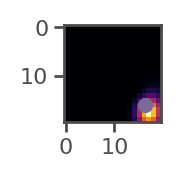

In [5]:
# Visualize PC network activity
timepoint = 3000
plt.figure()
plt.imshow(pc_activity[timepoint]) # decoded location of the animal based on PC bump
plt.scatter(Position[timepoint,0]*20, Position[timepoint,1]*20, s=20) # actual loation of the animal
plt.tight_layout()
plt.savefig('/Users/athinaapostolelli/Documents/SWC/VTC_modelling/figures/PCs/PC_bump_timepoint'+str(timepoint)+'.png')


  0%|          | 0/72000 [00:00<?, ?it/s]

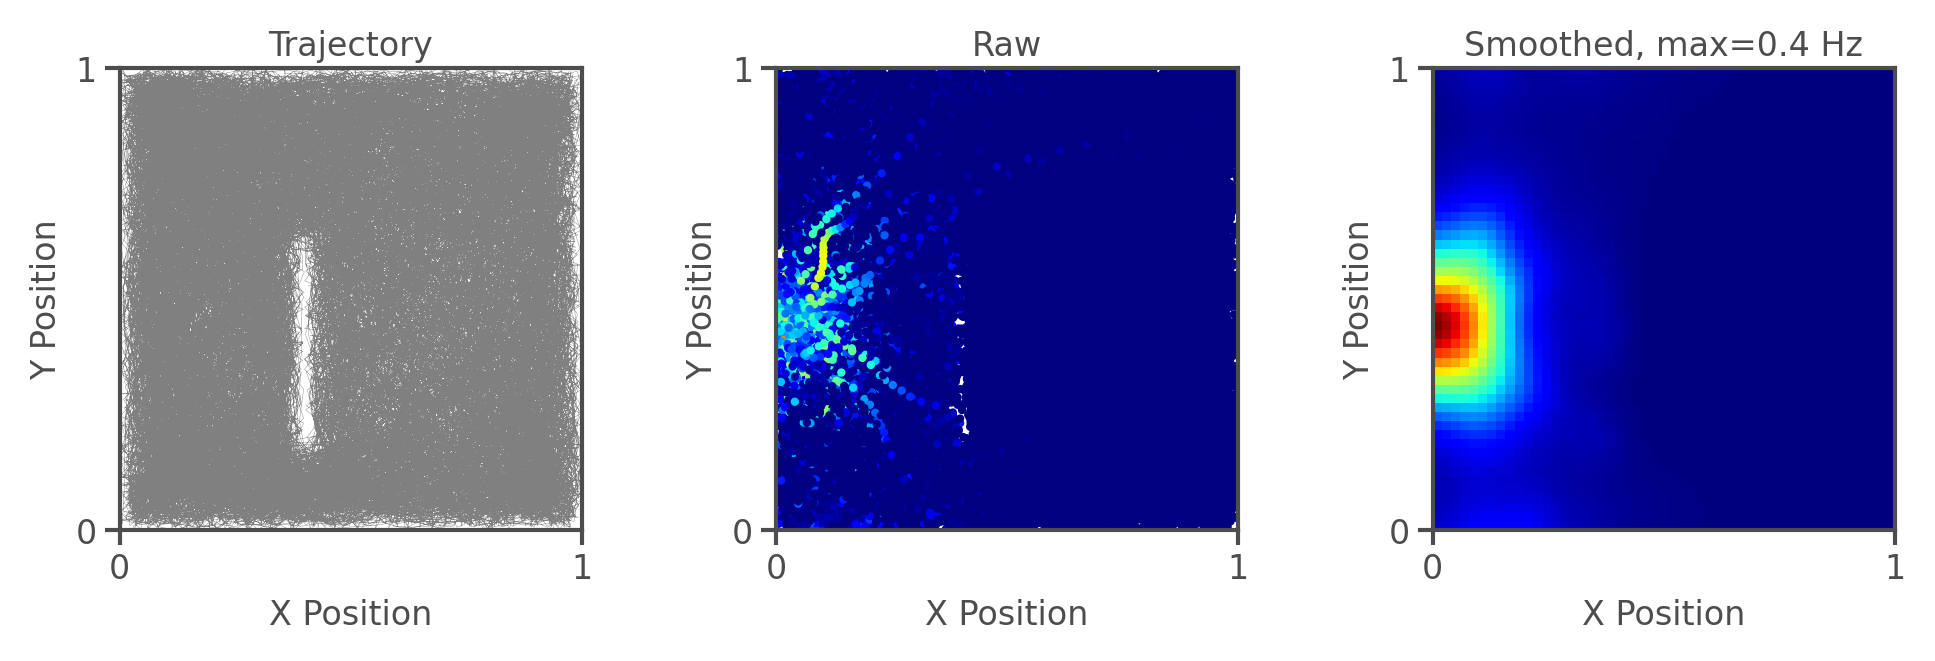

In [6]:
# Visualize firing rate maps 

# PC parameters
preferred_pc = [9, 0] # note this is [y,x]
x = np.linspace(0, 1, num_pc)
y = np.linspace(0, 1, num_pc)

d_i = [x[preferred_pc[1]], y[preferred_pc[0]]] # Preferred location of the PC.
beta = 0.2
sigma0 = 0.05
addnoise = False

# Compute firing rates 
firing_rates = compute_PC_firing_rate(Position, d_i, beta, sigma0, addnoise=addnoise)

# neuron_response = firing_rates # independent of 2D CAN
neuron_response = pc_activity[:, preferred_pc[0], preferred_pc[1]] # (N_pos, num_pc_y, num_pc_x)

# Create a single figure with 4 subplots (3 cartesian + 1 polar)
fig = plt.figure(figsize=(8, 2), dpi=300)

# -------------------------
# 1. Trajectory plot
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(Position[:,0], Position[:,1], lw=0.1, color='grey')

ax1.set_xlabel('X Position')
ax1.set_ylabel('Y Position')
ax1.set_aspect('equal')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_title("Trajectory")

# -------------------------
# 2. Raw firing map (scatter)
ax2 = fig.add_subplot(1, 3, 2)
sc = ax2.scatter(Position[:,0], Position[:,1], c=neuron_response, cmap='jet', s=1)

ax2.set_xlabel('X Position')
ax2.set_ylabel('Y Position')
ax2.set_aspect('equal')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_xticks([0, 1])
ax2.set_yticks([0, 1])
ax2.set_title("Raw")

# plt.colorbar(sc, ax=ax2, label='Firing Rate (Hz)', pad=0.2, shrink=0.7)

# -------------------------
# 3. Smoothed rate map
rate_map, dwell_times, spike_counts, extent = compute_firing_rate_map(Position, neuron_response, t, bin_size=0.02, smoothing="gaussian")

ax3 = fig.add_subplot(1, 3, 3)
c = ax3.imshow(rate_map.T, origin='lower', extent=[0, 1, 0, 1],
               cmap='jet', interpolation='nearest')

ax3.set_xlabel('X Position')
ax3.set_ylabel('Y Position')
ax3.set_aspect('equal')
max_fr_raw = np.nanmax(rate_map)
ax3.set_title(f"Smoothed, max={max_fr_raw:.1f} Hz")
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])
ax3.set_xticks([0, 1])
ax3.set_yticks([0, 1])

plt.savefig(f'/Users/athinaapostolelli/Documents/SWC/VTC_modelling/figures/PCs/PC_{d_i[0]:.2f}_{d_i[1]:.2f}.png')


In [7]:
# Generate spikes from PC network activity 
pc_spikes = np.random.poisson(pc_activity)

# spike_indices = np.argwhere(pc_spikes > 1) # (N_events, 3): [time_index, pc_x_index, pc_y_index]


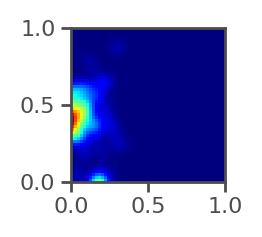

In [ ]:
# Plot rate map from generated spikes 
preferred_pc = [9, 0] # note this is [y,x]
neuron_response = pc_spikes[:, preferred_pc[0], preferred_pc[1]]

rate_map, dwell_times, spike_counts, extent = compute_firing_rate_map(Position, neuron_response, t, bin_size=0.02, smoothing="gaussian")

plt.figure()
plt.imshow(rate_map.T, origin='lower', extent=[0, 1, 0, 1], cmap='jet', interpolation='nearest')
plt.savefig(f'/Users/athinaapostolelli/Documents/SWC/VTC_modelling/figures/PCs/PC_PoissonSpikes_{d_i[0]:.2f}_{d_i[1]:.2f}.png')


### Create boundary vector cell layer 

In [10]:
# Run the BVC network on its own
bm.set_dt(1.0) #ms

# Construct the BVC network
BVC_net = BV_cell(noise_stre=0.,
                num_r=10,
                num_a=36,
                tau=10.0,
                tau_v=100.0,
                mbar=75.0,
                a=0.5,
                A=1.0,
                beta=0.2, #0.183, 
                sigma0=0.05, # 0.0122
                sigma_a=np.deg2rad(20), #0.2,
                J0=5.0,
                k=1,
                g = 1000,
                x_min=0.,
                x_max=1.,
                z_min=-bm.pi,
                z_max=bm.pi)

def run_BVCNet(i, Boundary_distance, Boundary_angle): 
    
    # Update the PC network 
    BVC_net.step_run(i, Boundary_distance, Boundary_angle)
    BVC_bumpactivity = BVC_net.r
    
    return BVC_bumpactivity


In [11]:
# Get single cell responses

# Get boundary distances and angles
boundary_segments = 360
boundary_distances, boundary_angles = get_boundary_distances(Position, Env, boundary_segments=boundary_segments)

# BVC parameters 
sigma_ang = np.deg2rad(20)
beta = 0.2
sigma0 = 0.05
# addnoise = False

# Compute firing rates 
# d_i = 0.05 # Preferred distance of the BVC.
# allo_ang = 165
# phi_i = np.deg2rad(allo_ang) # Preferred allocentric angle of the BVC (radians).
# delta_theta = 2 * np.pi / boundary_segments
# boundary_angle_range = np.linspace(-np.pi, np.pi, boundary_segments, endpoint=False)
# firing_rates = compute_BVC_firing_rate(Position, boundary_angle_range, delta_theta, phi_i, d_i, sigma_ang, beta, sigma0, addnoise=addnoise)

# Run the PC network
time_steps = np.arange(len(Position))
print('Running simulation...')

@bm.jit
def run(time, dist, angle):
    return bm.for_loop(run_BVCNet, (time, dist, angle))

# import zarr 
simulate_time = 1000  # every 100s perform the simulation, otherwise the gpu will run out of memory 

# Pre-allocate arrays
num_r = 10
num_a = 36

bvc_activity = np.empty((len(Position), num_r, num_a))

for i in range(0, len(Position), simulate_time):    
    print('Simulation progress: %.0f%%' % (i/len(Position)*100))
    bvc_activity_i = run(time_steps[i:i+simulate_time], 
                                            boundary_distances[i:i+simulate_time], 
                                            boundary_angles[i:i+simulate_time])
    
    bvc_activity[i:i+simulate_time,:,:] = np.asarray(bvc_activity_i).reshape((-1, num_r, num_a))


Running simulation...
Simulation progress: 0%
Simulation progress: 1%
Simulation progress: 3%
Simulation progress: 4%
Simulation progress: 6%
Simulation progress: 7%
Simulation progress: 8%
Simulation progress: 10%
Simulation progress: 11%
Simulation progress: 12%
Simulation progress: 14%
Simulation progress: 15%
Simulation progress: 17%
Simulation progress: 18%
Simulation progress: 19%
Simulation progress: 21%
Simulation progress: 22%
Simulation progress: 24%
Simulation progress: 25%
Simulation progress: 26%
Simulation progress: 28%
Simulation progress: 29%
Simulation progress: 31%
Simulation progress: 32%
Simulation progress: 33%
Simulation progress: 35%
Simulation progress: 36%
Simulation progress: 38%
Simulation progress: 39%
Simulation progress: 40%
Simulation progress: 42%
Simulation progress: 43%
Simulation progress: 44%
Simulation progress: 46%
Simulation progress: 47%
Simulation progress: 49%
Simulation progress: 50%
Simulation progress: 51%
Simulation progress: 53%
Simulation

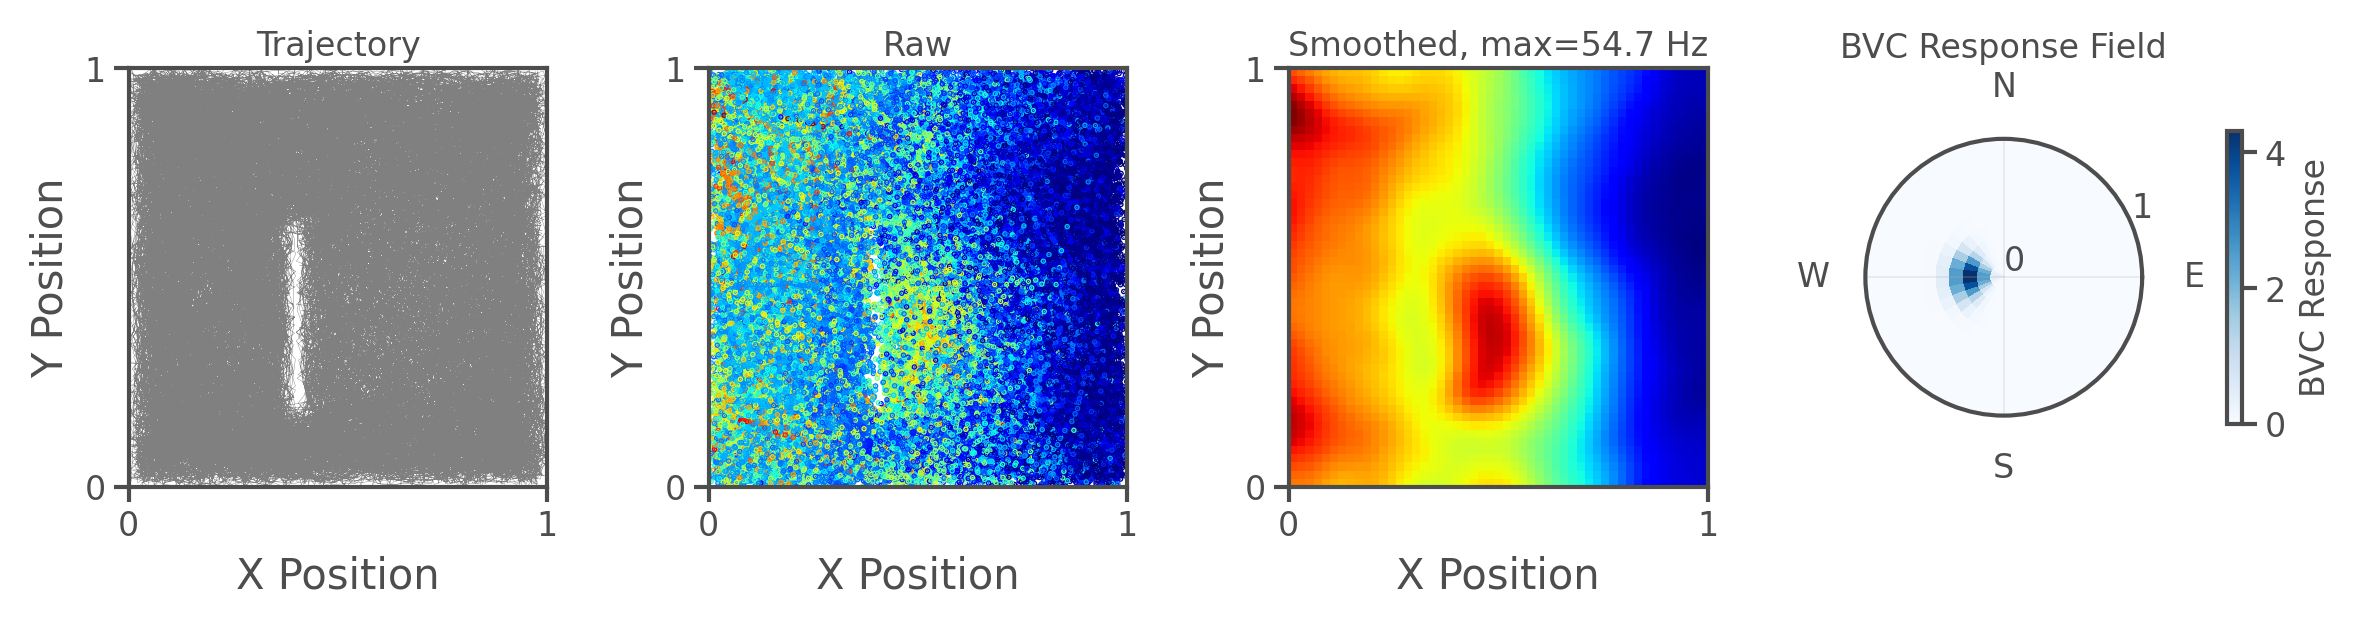

In [12]:
# Visualize firing rate maps
num_r = 10
num_a = 36
r = np.linspace(0, 1, num_r)
theta = np.linspace(-np.pi, np.pi, num_a)

# Select cell
radial_feature = 2          # [0:num_r]
angular_feature = 35        # [0:num_a] 
d_i = r[radial_feature]
phi_i = theta[angular_feature]
sigma_ang = np.deg2rad(20)
beta = 0.2
sigma0 = 0.05
# phi_i = np.deg2rad(phi_i) # Preferred allocentric angle of the BVC (radians).

neuron_response = bvc_activity[:, radial_feature, angular_feature]

# Create a single figure with 4 subplots (3 cartesian + 1 polar)
fig = plt.figure(figsize=(8, 2), dpi=300)

# -------------------------
# 1. Trajectory plot
ax1 = fig.add_subplot(1, 4, 1)
ax1.plot(Position[:,0], Position[:,1], lw=0.1, color='grey')

ax1.set_xlabel('X Position')
ax1.set_ylabel('Y Position')
ax1.set_aspect('equal')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_title("Trajectory")

# -------------------------
# 2. Raw firing map (scatter)
ax2 = fig.add_subplot(1, 4, 2)
sc = ax2.scatter(Position[:,0], Position[:,1], c=neuron_response, cmap='jet', s=0.1)

ax2.set_xlabel('X Position')
ax2.set_ylabel('Y Position')
ax2.set_aspect('equal')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_xticks([0, 1])
ax2.set_yticks([0, 1])
ax2.set_title("Raw")

# plt.colorbar(sc, ax=ax2, label='Firing Rate (Hz)', pad=0.2, shrink=0.7)

# -------------------------
# 3. Smoothed rate map
rate_map, dwell_times, spike_counts, extent = compute_firing_rate_map(Position, neuron_response, t, bin_size=0.02, smoothing="gaussian")

ax3 = fig.add_subplot(1, 4, 3)
c = ax3.imshow(rate_map.T, origin='lower', extent=[0, 1, 0, 1],
               cmap='jet', interpolation='nearest')

ax3.set_xlabel('X Position')
ax3.set_ylabel('Y Position')
ax3.set_aspect('equal')
max_fr_raw = np.nanmax(rate_map)
ax3.set_title(f"Smoothed, max={max_fr_raw:.1f} Hz")
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])
ax3.set_xticks([0, 1])
ax3.set_yticks([0, 1])

# -------------------------
# 4. BVC Polar Tuning
ax4 = fig.add_subplot(1, 4, 4, projection='polar')

Theta, R = np.meshgrid(theta, r)
response = BVC_response(Theta, R, phi_i, d_i, sigma_ang, beta, sigma0)

r_edges = np.linspace(r.min(), r.max(), len(r)+1)
theta_edges = np.linspace(theta.min(), theta.max(), len(theta)+1)

pcm = ax4.pcolormesh(theta_edges, r_edges, response, cmap='Blues', shading='auto')
plt.colorbar(pcm, ax=ax4, label='BVC Response', pad=0.2, shrink=0.7)

ax4.set_title("BVC Response Field")
ax4.set_theta_zero_location("E")
ax4.set_theta_direction(1)
ax4.set_ylim(0, 1)
ax4.set_yticks([0, 1])
ax4.set_thetagrids([0, 90, 180, 270], labels=['E', 'N', 'W', 'S'])

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel(ax.get_xlabel(), fontsize=10)
    ax.set_ylabel(ax.get_ylabel(), fontsize=10)

# -------------------------
# Final layout
plt.tight_layout()

plt.savefig('/Users/athinaapostolelli/Documents/SWC/VTC_modelling/figures/BVCs/BVC_'+str(np.round(d_i,1))+'_'+str(np.round(np.rad2deg(phi_i),1))+'.png')


In [13]:
# Generate spikes from BVC layer activity 
bvc_spikes = np.random.poisson(bvc_activity)

[2 2 0 ... 0 0 0]


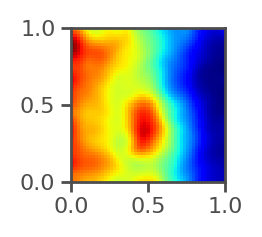

In [ ]:
# Plot rate map from generated spikes 
d_i = r[radial_feature]
phi_i = theta[angular_feature]

neuron_response = bvc_spikes[:, radial_feature, angular_feature]

rate_map, dwell_times, spike_counts, extent = compute_firing_rate_map(Position, neuron_response, t, bin_size=0.02, smoothing="gaussian")

plt.figure()
plt.imshow(rate_map.T, origin='lower', extent=[0, 1, 0, 1], cmap='jet', interpolation='nearest')
plt.savefig(f'/Users/athinaapostolelli/Documents/SWC/VTC_modelling/figures/BVCs/BVC_PoissonSpikes_{d_i:.2f}_{phi_i:.2f}.png')


### Associate PC network with BVC network 